# Gaussian Mixture Model (GMM)

The nonprobabilistic nature of k-means and its use of simple distance from cluster center to assign cluster membership leads to poor performance for many real-world situations.

GMM can be viewed as an extension of the ideas behind k-means.

The assumption behind a GMM is that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. All the instances generated from the same Gaussian distribution form a cluster that typically looks like an ellipsoid. Each cluster can have a different ellipsoidal shape, size, density, and orientation.

When observing the instance, we don't know which Gaussian distribution it was generated from and the parameters of the distribution.

A GMM attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.

In the simplest implementation, the number of $k$ Gaussian distribution must be known in advance.

## GMM with Python

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
plt.set_cmap('viridis')

<Figure size 640x480 with 0 Axes>

In [20]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [21]:
from sklearn.mixture import GaussianMixture

In [22]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

This class relies on the expectation-maximization (EM) algorithm, which has many similarities with the k-means algorithm: it also initializes the cluster parameters randomly, then it repeats two steps until convergence, first assigning instances to clusters (this is called the expectation step) and then updating the clusters (this is called the maximization step).

EM can end up converging to poor solutions, so it needs to be run several times, keeping only the best solution. This is why we set `n_init` to 10. Be careful: by default `n_init` is set to 1.

In [23]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [24]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [25]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

To check whether it converged and how many iterations it took, you can look at the `converged_` and `n_iter_` attributes:

In [26]:
gm.converged_

True

In [27]:
gm.n_iter_

4

Now that you have an estimate of the location, size, shape, orientation, and relative weight of each cluster, the model can easily assign each instance to the most likely cluster (hard clustering) or estimate the probability that it belongs to a particular cluster (soft clustering). Just use the predict() method for hard clustering, or the predict_proba() method for soft clustering:

In [28]:
gm.predict_proba(X)

array([[6.76282339e-07, 2.31833274e-02, 9.76815996e-01],
       [6.74575575e-04, 1.64110061e-02, 9.82914418e-01],
       [9.99922764e-01, 1.99781831e-06, 7.52377580e-05],
       ...,
       [2.12540639e-26, 9.99999568e-01, 4.31902443e-07],
       [1.45002917e-41, 1.00000000e+00, 5.20915318e-16],
       [7.93266114e-41, 1.00000000e+00, 2.30971331e-15]], shape=(1250, 3))

In [29]:
gm.predict_proba(X).round(3)

array([[0.   , 0.023, 0.977],
       [0.001, 0.016, 0.983],
       [1.   , 0.   , 0.   ],
       ...,
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ]], shape=(1250, 3))

A Gaussian mixture model is a generative model, meaning you can sample new instances from it (note that they are ordered by cluster index):

In [30]:
X_new, y_new = gm.sample(6)
X_new

array([[-2.32491052,  1.04752548],
       [-1.16654983,  1.62795173],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [ 0.38079484, -0.56239369]])

In [31]:
y_new

array([0, 0, 1, 1, 1, 2])

It is also possible to estimate the density of the model at any given location. This is achieved using the `score_samples()` method: for each instance it is given, this method estimates the log of the probability density function (PDF) at that location. The greater the score, the higher the density:

In [32]:
gm.score_samples(X).round(2)

array([-2.61, -3.57, -3.33, ..., -3.51, -4.4 , -3.81], shape=(1250,))

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [33]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

np.float64(0.9999999999225088)

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

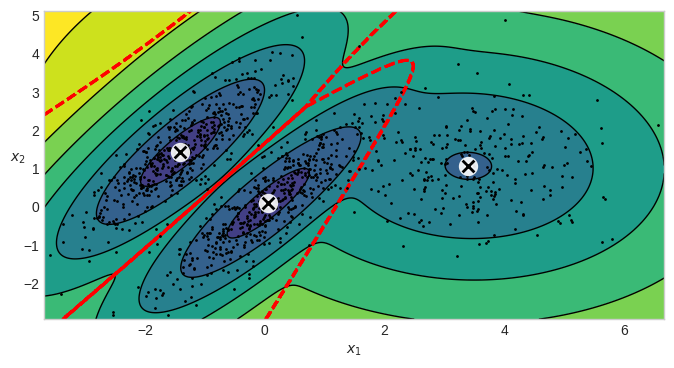

In [34]:
from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.show()

When there are many dimensions, or many clusters, or few instances, EM can struggle to converge to the optimal solution. You might need to reduce the difficulty of the task by limiting the number of parameters that the algorithm has to learn. One way to do this is to limit the range of shapes and orientations that the clusters can have. This can be achieved by imposing constraints on the covariance matrices. To do this, set the `covariance_type` hyperparameter to one of the following values:

- *spherical*: all clusters must be spherical, but they can have different diameters (i.e., different variances).
- *diag*: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).
- *tied*: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
- *full* (default): no constraint, all clusters can take on any ellipsoidal shape of any size.

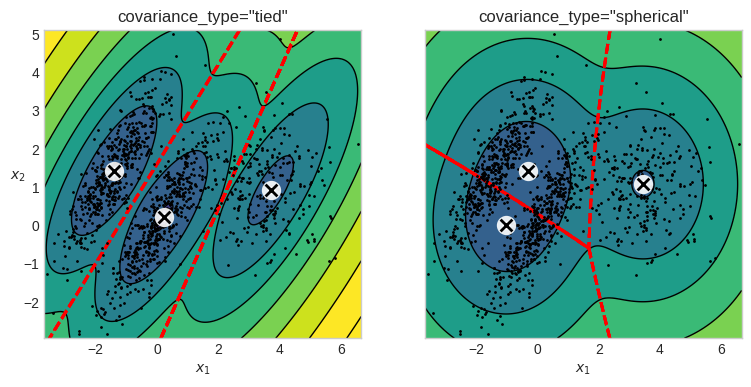

In [35]:
gm_full = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10,
                               covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title(f'covariance_type="{gm1.covariance_type}"')

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title(f'covariance_type="{gm2.covariance_type}"')

compare_gaussian_mixtures(gm_tied, gm_spherical, X)


plt.show()

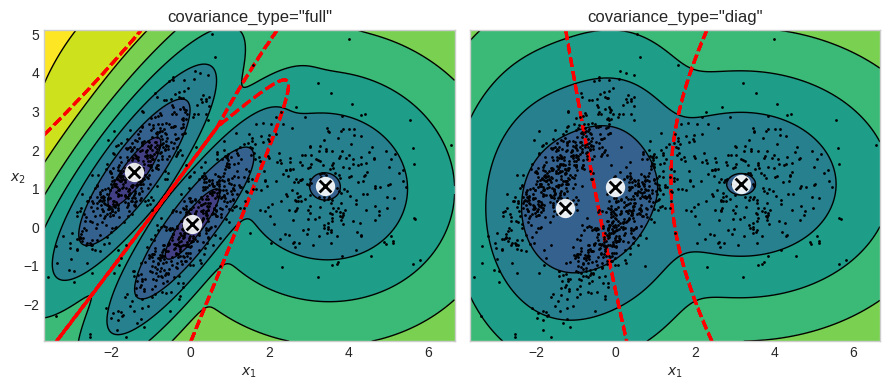

In [36]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Anomaly Detection using GMM


Gaussian Mixtures can be used for anomaly detection: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 2%, then you can set the density threshold to be the value that results in having 2% of the instances located in areas below that threshold density:

In [37]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]

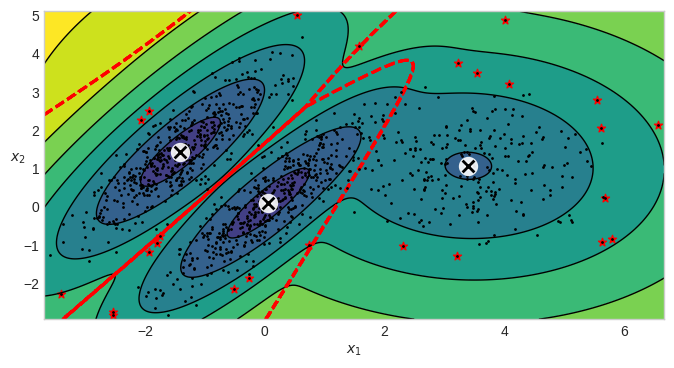

In [38]:
plt.figure(figsize=(8, 4))
plt.set_cmap('viridis')
plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

## GMM as Density Estimation

Though the GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for density estimation. That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

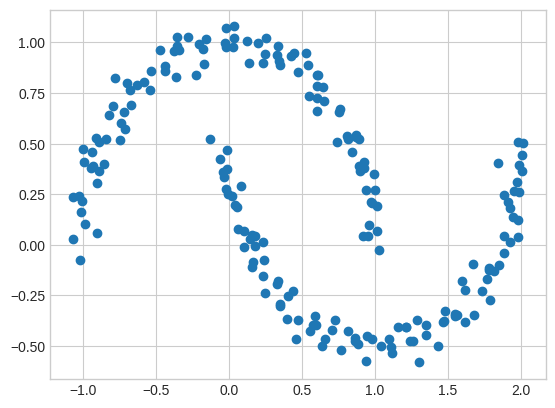

In [39]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

In [40]:
gmm_2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)

In [41]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Handle different covariance types
    if np.isscalar(covariance):
        # Spherical case - scalar variance
        covariance = np.eye(2) * covariance
    elif covariance.ndim == 1:
        # Diagonal case - 1D array of variances
        covariance = np.diag(covariance)

    # Now covariance should be a 2x2 matrix
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle=angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()

    # Handle different covariance types correctly
    if gmm.covariance_type == 'tied':
        # All components share the same covariance
        for pos, w in zip(gmm.means_, gmm.weights_):
            draw_ellipse(pos, gmm.covariances_, ax, alpha=w * w_factor)
    else:
        # Each component has its own covariance
        for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
            draw_ellipse(pos, covar, ax, alpha=w * w_factor)

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful (see the following figure):

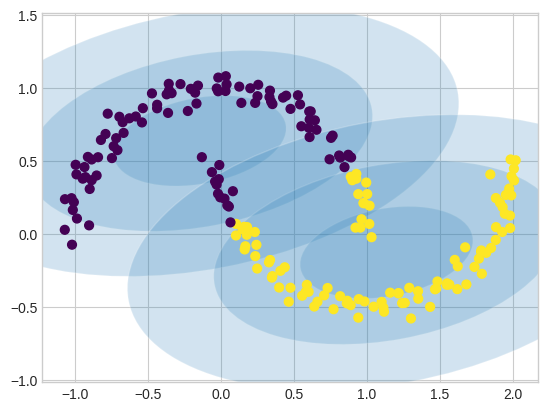

In [42]:
plot_gmm(gmm_2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data (see the following figure):

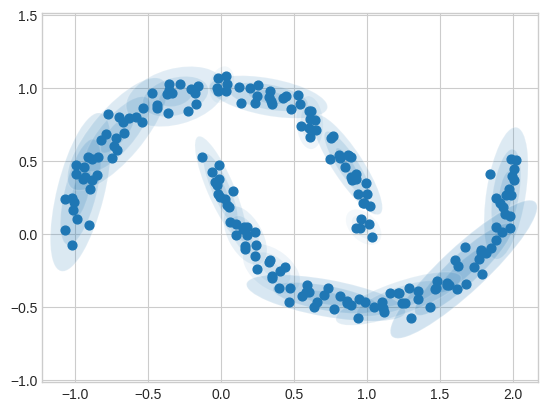

In [43]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussian components serves not to find separated clusters of data, but rather to model the overall distribution of the input data. This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input. For example, here are 400 new points drawn from this 16-component GMM fit to our original data (see the following figure):

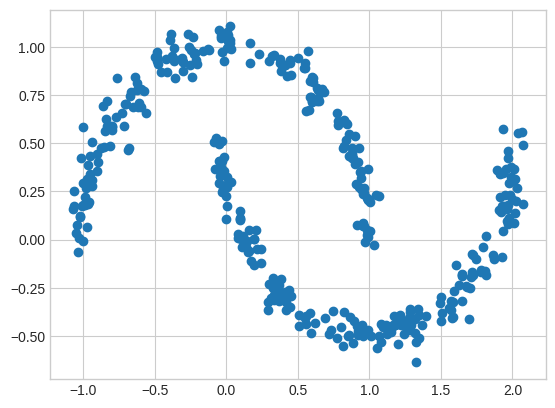

In [44]:
Xnew, ynew = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

## Determining the number of components

 A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the likelihood of the data under the model, using cross-validation to avoid overfitting. Another means of correcting for overfitting is to adjust the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC). Scikit-Learn's GaussianMixture estimator actually includes built-in methods that compute both of these, so it is very easy to operate using this approach.

Let's look at the AIC and BIC versus the number of GMM components for our moons dataset (see the following figure):

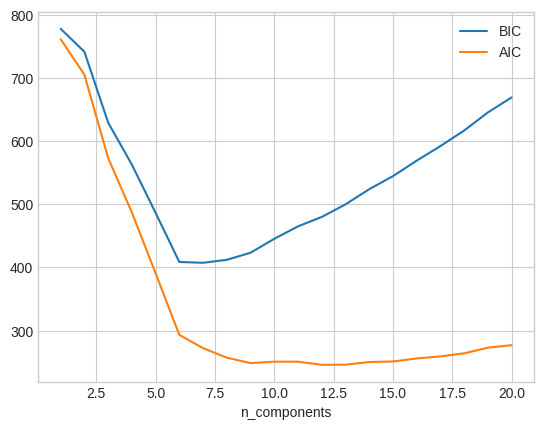

In [45]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

Both are calculated as follows, where:

- $m$ is the number of instances
- $p$ is the number of parameters learned by the model
- $\hat{L}$ is the maximized value of the likelihood function of the model (the conditional probability of the observed data $\mathbf{X}$ given the model and estimated parameters)

$$BIC = log(m)p - 2log(\hat{L})$$

$$AIC = 2p - 2log(\hat{L})$$

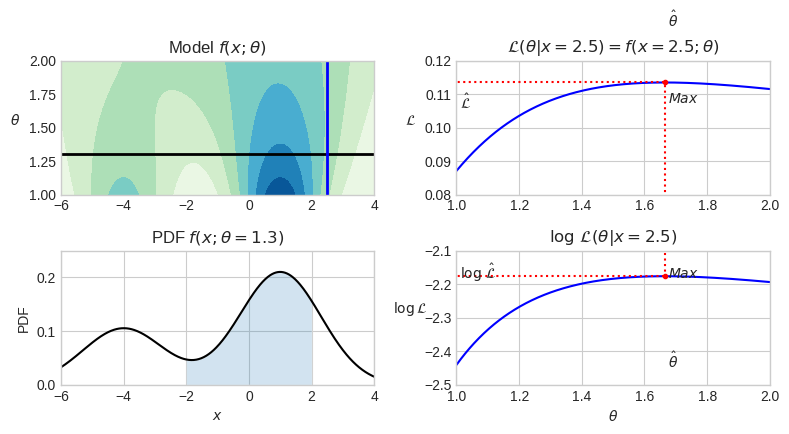

In [60]:
from scipy.stats import norm

def create_model_data(x_range, stds_range, points=501):
    """Generate data grid and mixture of Gaussians."""
    xs = np.linspace(x_range[0], x_range[1], points)
    stds = np.linspace(stds_range[0], stds_range[1], points)
    Xs, Stds = np.meshgrid(xs, stds)

    # Create mixture of two Gaussians
    Z = 2 * norm.pdf(Xs - 1.0, 0, Stds) + norm.pdf(Xs + 4.0, 0, Stds)
    # Normalize to create proper PDF
    Z /= Z.sum(axis=1, keepdims=True) * (xs[1] - xs[0])

    return xs, stds, Xs, Stds, Z

def plot_with_maximum(ax, x_values, y_values, ylim, max_label, point_label, function_label):
    """Plot a function and highlight its maximum."""
    ax.plot(x_values, y_values, "b-")

    # Find maximum
    max_idx = y_values.argmax()
    max_val = y_values[max_idx]

    # Plot maximum point and reference lines
    ax.plot(x_values[max_idx], max_val, "r.")
    ax.plot([x_values[max_idx], x_values[max_idx]], [0, max_val], "r:")
    ax.plot([0, x_values[max_idx]], [max_val, max_val], "r:")

    # Add labels
    ax.text(x_values[max_idx] + 0.01, ylim[0] + 0.05, point_label)
    ax.text(x_values[max_idx] + 0.01, max_val - 0.006, max_label)
    ax.text(1.01, max_val - 0.008, function_label)

    ax.axis([1, 2, ylim[0], ylim[1]])

# Parameters
x_val = 2.5
std_val = 1.3
x_range = [-6, 4]
x_proba_range = [-2, 2]
stds_range = [1, 2]

# Generate data
xs, stds, Xs, Stds, Z = create_model_data(x_range, stds_range)

# Find indices for example points
x_example_idx = np.searchsorted(xs, x_val)
s_example_idx = np.searchsorted(stds, std_val)
x_range_min_idx = np.searchsorted(xs, x_proba_range[0])
x_range_max_idx = np.searchsorted(xs, x_proba_range[1])

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 4.5))

# Plot 1: Model contour (top-left)
axes[0, 0].contourf(Xs, Stds, Z, cmap="GnBu")
axes[0, 0].plot([-6, 4], [std_val, std_val], "k-", linewidth=2)
axes[0, 0].plot([x_val, x_val], [1, 2], "b-", linewidth=2)
axes[0, 0].set_ylabel(r"$\theta$", rotation=0, labelpad=10)
axes[0, 0].set_title(r"Model $f(x; \theta)$")

# Plot 2: Likelihood function (top-right)
plot_with_maximum(
    axes[0, 1], stds, Z[:, x_example_idx],
    [0.08, 0.12], r"$Max$", r"$\hat{\theta}$", r"$\hat{\mathcal{L}}$"
)
axes[0, 1].set_ylabel(r"$\mathcal{L}$", rotation=0, labelpad=10)
axes[0, 1].set_title(fr"$\mathcal{{L}}(\theta|x={x_val}) = f(x={x_val}; \theta)$")

# Plot 3: PDF for specific theta (bottom-left)
axes[1, 0].plot(xs, Z[s_example_idx], "k-")
axes[1, 0].fill_between(
    xs[x_range_min_idx:x_range_max_idx+1],
    Z[s_example_idx, x_range_min_idx:x_range_max_idx+1],
    alpha=0.2
)
axes[1, 0].set_xlabel(r"$x$")
axes[1, 0].set_ylabel("PDF")
axes[1, 0].set_title(fr"PDF $f(x; \theta={std_val})$")
axes[1, 0].axis([-6, 4, 0, 0.25])

# Plot 4: Log-likelihood function (bottom-right)
log_likelihood = np.log(Z[:, x_example_idx])
plot_with_maximum(
    axes[1, 1], stds, log_likelihood,
    [-2.5, -2.1], r"$Max$", r"$\hat{\theta}$", r"$\log \, \hat{\mathcal{L}}$"
)
axes[1, 1].set_xlabel(r"$\theta$")
axes[1, 1].set_ylabel(r"$\log\mathcal{L}$", rotation=0, labelpad=10)
axes[1, 1].set_title(fr"$\log \, \mathcal{{L}}(\theta|x={x_val})$")

plt.tight_layout()
plt.show()

In [61]:
gm.bic(X)

np.float64(8189.733705221636)

In [62]:
gm.aic(X)

np.float64(8102.508425106598)

In [63]:
def count_gmm_parameters(n_clusters, n_features, covariance_type='full'):
    """Calculate the number of parameters in a Gaussian Mixture Model."""
    # Mixture weights (minus 1 because they sum to 1)
    n_weights_params = n_clusters - 1

    # Mean parameters
    n_means_params = n_clusters * n_features

    # Covariance parameters
    if covariance_type == 'full':
        # Each component has its own covariance matrix
        n_cov_params = n_clusters * n_features * (n_features + 1) // 2
    elif covariance_type == 'tied':
        # All components share the same covariance matrix
        n_cov_params = n_features * (n_features + 1) // 2
    elif covariance_type == 'diag':
        # Each component has a diagonal covariance matrix
        n_cov_params = n_clusters * n_features
    elif covariance_type == 'spherical':
        # Each component has a single variance parameter
        n_cov_params = n_clusters
    else:
        raise ValueError(f"Invalid covariance_type: {covariance_type}")

    return n_weights_params + n_means_params + n_cov_params

def calculate_information_criteria(gmm, X):
    """Calculate BIC and AIC for a fitted Gaussian Mixture Model."""
    n_samples = X.shape[0]
    n_features = X.shape[1]

    # Calculate number of parameters
    n_params = count_gmm_parameters(
        gmm.n_components,
        n_features,
        gmm.covariance_type
    )

    # Calculate log-likelihood
    log_likelihood = gmm.score(X) * n_samples

    # Calculate BIC and AIC
    bic = np.log(n_samples) * n_params - 2 * log_likelihood
    aic = 2 * n_params - 2 * log_likelihood

    return {
        'bic': bic,
        'aic': aic,
        'n_params': n_params,
        'log_likelihood': log_likelihood
    }

# Calculate and display the information criteria
info = calculate_information_criteria(gm, X)
print(f"BIC: {info['bic']:.2f}")
print(f"AIC: {info['aic']:.2f}")
print(f"Number of parameters: {info['n_params']}")
print(f"Log-likelihood: {info['log_likelihood']:.2f}")

# Verify against sklearn's built-in methods
print(f"\nSklearn BIC: {gm.bic(X):.2f}")
print(f"Sklearn AIC: {gm.aic(X):.2f}")

BIC: 8189.73
AIC: 8102.51
Number of parameters: 17
Log-likelihood: -4034.25

Sklearn BIC: 8189.73
Sklearn AIC: 8102.51


Fitting GMMs:   0%|          | 0/10 [00:00<?, ?it/s]

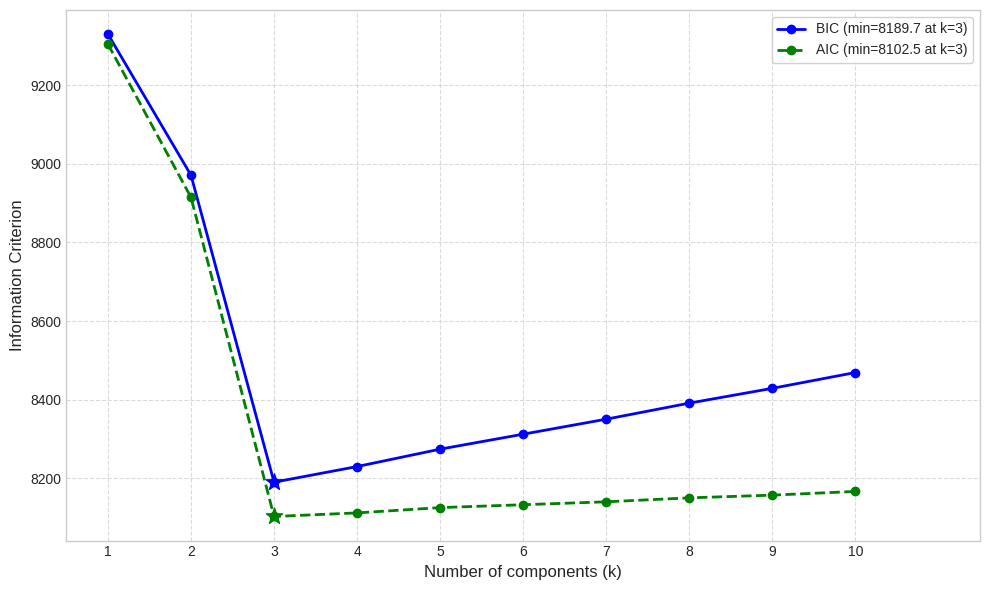

Optimal number of components based on BIC: 3
Optimal number of components based on AIC: 3


In [67]:
from tqdm.notebook import tqdm  # Re-adding tqdm for progress tracking

def fit_multiple_gmms(X, components_range, n_init=10, random_state=42, covariance_type='full'):
    """
    Fit multiple Gaussian Mixture Models with different numbers of components.
    """
    results = {'k_values': list(components_range), 'models': [], 'bic': [], 'aic': []}

    for k in tqdm(components_range, desc="Fitting GMMs"):
        gm = GaussianMixture(
            n_components=k,
            n_init=n_init,
            random_state=random_state,
            covariance_type=covariance_type
        ).fit(X)

        results['models'].append(gm)
        results['bic'].append(gm.bic(X))
        results['aic'].append(gm.aic(X))

    return results

def plot_information_criteria(results, figsize=(10, 6)):
    """
    Plot BIC and AIC values with the minimum values shown in the legend.
    """
    k_values = results['k_values']
    bic_values = results['bic']
    aic_values = results['aic']

    # Find minimum values
    min_bic_idx = np.argmin(bic_values)
    min_aic_idx = np.argmin(aic_values)
    min_bic = bic_values[min_bic_idx]
    min_aic = aic_values[min_aic_idx]

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot BIC and AIC curves
    ax.plot(k_values, bic_values, "bo-", linewidth=2,
            label=f"BIC (min={min_bic:.1f} at k={k_values[min_bic_idx]})")
    ax.plot(k_values, aic_values, "go--", linewidth=2,
            label=f"AIC (min={min_aic:.1f} at k={k_values[min_aic_idx]})")

    # Highlight minimum values with stars
    ax.scatter(k_values[min_bic_idx], min_bic, s=150, c='blue', marker='*', zorder=5)
    ax.scatter(k_values[min_aic_idx], min_aic, s=150, c='green', marker='*', zorder=5)

    # Set plot attributes
    ax.set_xlabel("Number of components (k)", fontsize=12)
    ax.set_ylabel("Information Criterion", fontsize=12)
    #ax.set_title("BIC and AIC values for different numbers of GMM components", fontsize=14)
    ax.set_xticks(k_values)
    ax.set_xlim(min(k_values) - 0.5, max(k_values) + 1.5)

    # Add grid and enhanced legend
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10, loc='best', framealpha=0.9, frameon=True)

    plt.tight_layout()
    return fig

# Usage example:
components_range = range(1, 11)
results = fit_multiple_gmms(X, components_range)
plot_information_criteria(results)
plt.show()

# Print optimal number of components
print(f"Optimal number of components based on BIC: {results['k_values'][np.argmin(results['bic'])]}")
print(f"Optimal number of components based on AIC: {results['k_values'][np.argmin(results['aic'])]}")